In [1]:
!pip list | grep -E 'qiskit|torch'

qiskit                        0.43.3
qiskit-aer-gpu                0.12.2
qiskit-dynamics               0.4.1
qiskit-experiments            0.5.3
qiskit-finance                0.3.4
qiskit-ibm-experiment         0.3.3
qiskit-ibm-provider           0.6.1
qiskit-ibm-runtime            0.11.2
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.0
qiskit-nature                 0.6.2
qiskit-optimization           0.5.0
qiskit-qasm3-import           0.2.0
qiskit-sphinx-theme           1.12.1
qiskit-terra                  0.25.0
torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchsummary                  1.5.1
torchvision                   0.15.2+cu118


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [3]:
data_dir = '../dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [7]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [10]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [11]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [12]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 69425.921875
	 partial train loss (single batch): 67554.523438
	 partial train loss (single batch): 65954.070312
	 partial train loss (single batch): 64689.441406
	 partial train loss (single batch): 63362.695312
	 partial train loss (single batch): 62233.828125
	 partial train loss (single batch): 61507.375000
	 partial train loss (single batch): 60691.625000
	 partial train loss (single batch): 59962.832031
	 partial train loss (single batch): 59362.820312
	 partial train loss (single batch): 59084.652344
	 partial train loss (single batch): 58337.804688
	 partial train loss (single batch): 57615.890625
	 partial train loss (single batch): 57334.328125
	 partial train loss (single batch): 56971.195312
	 partial train loss (single batch): 56346.460938
	 partial train loss (single batch): 55545.859375
	 partial train loss (single batch): 55489.597656
	 partial train loss (single batch): 55241.109375
	 partial train loss (single batch): 54734.035156


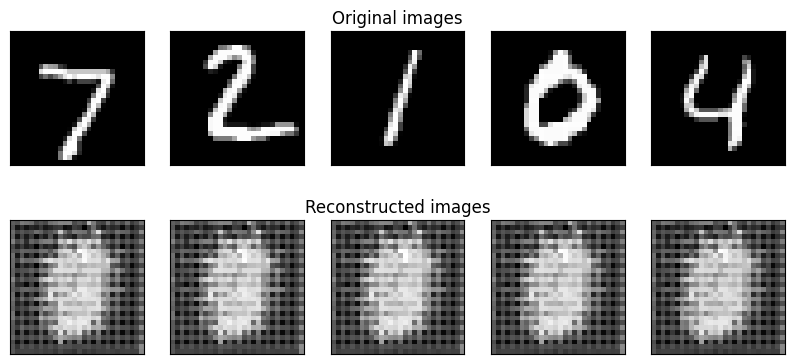

	 partial train loss (single batch): 19937.462891
	 partial train loss (single batch): 19922.173828
	 partial train loss (single batch): 19754.740234
	 partial train loss (single batch): 19659.494141
	 partial train loss (single batch): 19562.779297
	 partial train loss (single batch): 19531.066406
	 partial train loss (single batch): 19346.169922
	 partial train loss (single batch): 19429.679688
	 partial train loss (single batch): 19354.371094
	 partial train loss (single batch): 19214.396484
	 partial train loss (single batch): 19027.652344
	 partial train loss (single batch): 19158.175781
	 partial train loss (single batch): 19057.925781
	 partial train loss (single batch): 19035.742188
	 partial train loss (single batch): 18841.214844
	 partial train loss (single batch): 18756.041016
	 partial train loss (single batch): 19047.076172
	 partial train loss (single batch): 18751.046875
	 partial train loss (single batch): 18787.535156
	 partial train loss (single batch): 18556.507812


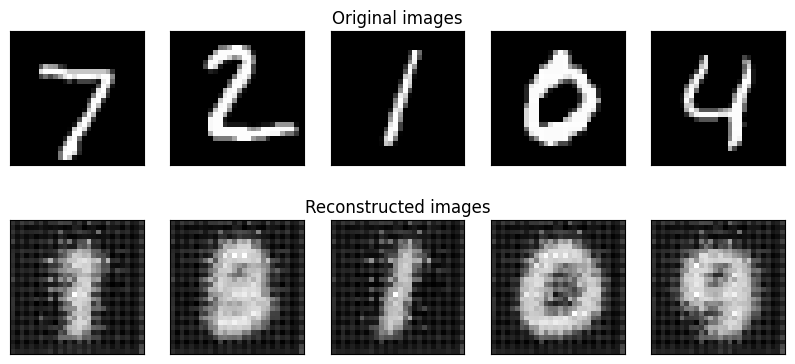

	 partial train loss (single batch): 13525.500000
	 partial train loss (single batch): 13607.930664
	 partial train loss (single batch): 13696.763672
	 partial train loss (single batch): 13388.233398
	 partial train loss (single batch): 13613.794922
	 partial train loss (single batch): 13368.523438
	 partial train loss (single batch): 13439.169922
	 partial train loss (single batch): 13675.081055
	 partial train loss (single batch): 13361.458984
	 partial train loss (single batch): 13433.124023
	 partial train loss (single batch): 13107.745117
	 partial train loss (single batch): 13233.640625
	 partial train loss (single batch): 13412.641602
	 partial train loss (single batch): 13303.643555
	 partial train loss (single batch): 13105.912109
	 partial train loss (single batch): 13173.037109
	 partial train loss (single batch): 13611.777344
	 partial train loss (single batch): 13076.824219
	 partial train loss (single batch): 13219.340820
	 partial train loss (single batch): 13161.287109


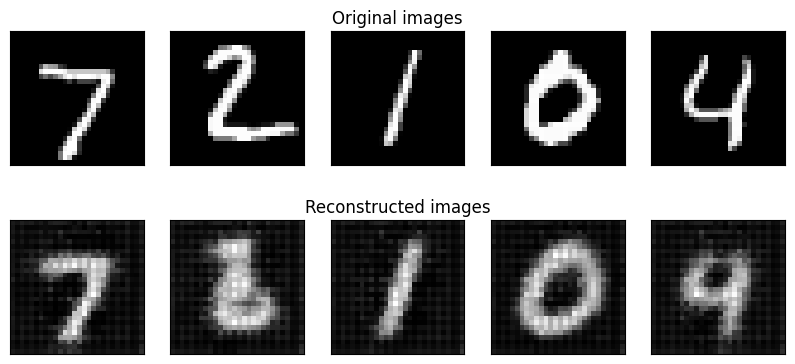

	 partial train loss (single batch): 10987.458984
	 partial train loss (single batch): 11008.907227
	 partial train loss (single batch): 11078.996094
	 partial train loss (single batch): 10861.877930
	 partial train loss (single batch): 11095.182617
	 partial train loss (single batch): 10838.264648
	 partial train loss (single batch): 10880.455078
	 partial train loss (single batch): 11309.037109
	 partial train loss (single batch): 10736.129883
	 partial train loss (single batch): 10891.403320
	 partial train loss (single batch): 10547.005859
	 partial train loss (single batch): 10664.681641
	 partial train loss (single batch): 10985.065430
	 partial train loss (single batch): 10973.772461
	 partial train loss (single batch): 10638.293945
	 partial train loss (single batch): 10655.360352
	 partial train loss (single batch): 11155.255859
	 partial train loss (single batch): 10693.119141
	 partial train loss (single batch): 10822.109375
	 partial train loss (single batch): 10765.984375


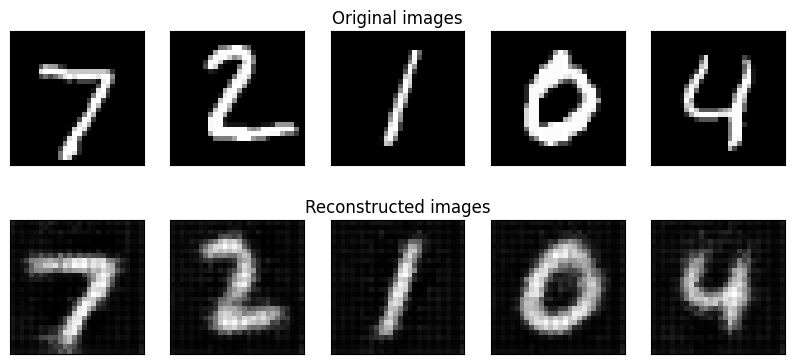

	 partial train loss (single batch): 10111.975586
	 partial train loss (single batch): 9805.788086
	 partial train loss (single batch): 9939.271484
	 partial train loss (single batch): 9843.052734
	 partial train loss (single batch): 10088.951172
	 partial train loss (single batch): 9854.964844
	 partial train loss (single batch): 9863.805664
	 partial train loss (single batch): 10365.588867
	 partial train loss (single batch): 9671.566406
	 partial train loss (single batch): 9879.108398
	 partial train loss (single batch): 9495.731445
	 partial train loss (single batch): 9703.287109
	 partial train loss (single batch): 9974.573242
	 partial train loss (single batch): 10116.525391
	 partial train loss (single batch): 9644.913086
	 partial train loss (single batch): 9619.907227
	 partial train loss (single batch): 10240.782227
	 partial train loss (single batch): 9758.246094
	 partial train loss (single batch): 9853.552734
	 partial train loss (single batch): 9831.032227
	 partial train

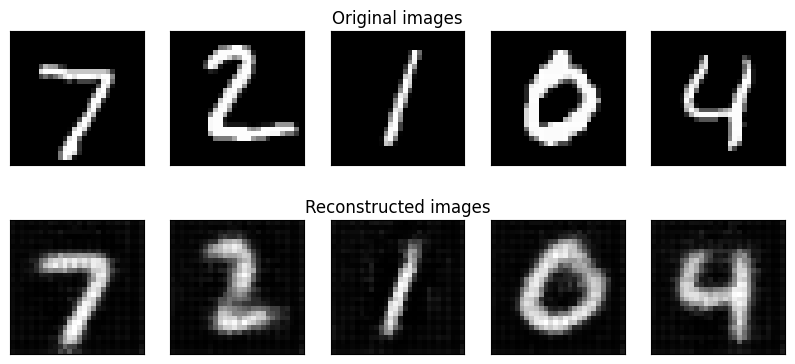

	 partial train loss (single batch): 9545.618164
	 partial train loss (single batch): 9224.343750
	 partial train loss (single batch): 9359.525391
	 partial train loss (single batch): 9441.598633
	 partial train loss (single batch): 9548.906250
	 partial train loss (single batch): 9421.307617
	 partial train loss (single batch): 9391.386719
	 partial train loss (single batch): 9902.523438
	 partial train loss (single batch): 9227.479492
	 partial train loss (single batch): 9525.574219
	 partial train loss (single batch): 9012.035156
	 partial train loss (single batch): 9216.800781
	 partial train loss (single batch): 9498.351562
	 partial train loss (single batch): 9714.282227
	 partial train loss (single batch): 9158.944336
	 partial train loss (single batch): 9267.615234
	 partial train loss (single batch): 9770.199219
	 partial train loss (single batch): 9274.738281
	 partial train loss (single batch): 9398.267578
	 partial train loss (single batch): 9421.619141
	 partial train loss

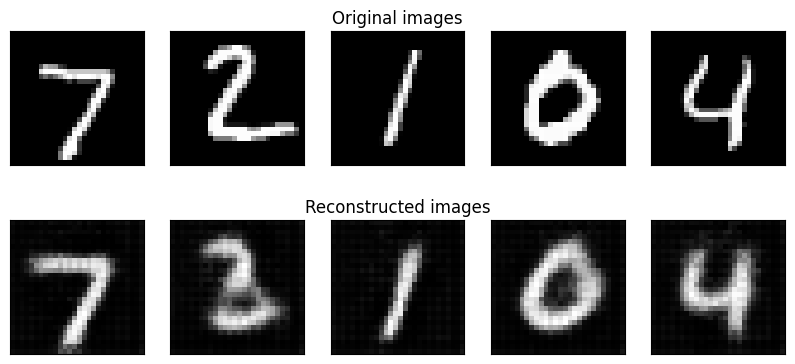

	 partial train loss (single batch): 9413.332031
	 partial train loss (single batch): 9099.403320
	 partial train loss (single batch): 9141.741211
	 partial train loss (single batch): 9217.335938
	 partial train loss (single batch): 9316.279297
	 partial train loss (single batch): 9194.785156
	 partial train loss (single batch): 9158.934570
	 partial train loss (single batch): 9662.138672
	 partial train loss (single batch): 8947.590820
	 partial train loss (single batch): 9305.118164
	 partial train loss (single batch): 8801.412109
	 partial train loss (single batch): 9077.746094
	 partial train loss (single batch): 9214.292969
	 partial train loss (single batch): 9443.658203
	 partial train loss (single batch): 8964.825195
	 partial train loss (single batch): 8937.682617
	 partial train loss (single batch): 9496.205078
	 partial train loss (single batch): 9017.299805
	 partial train loss (single batch): 9207.716797
	 partial train loss (single batch): 9151.910156
	 partial train loss

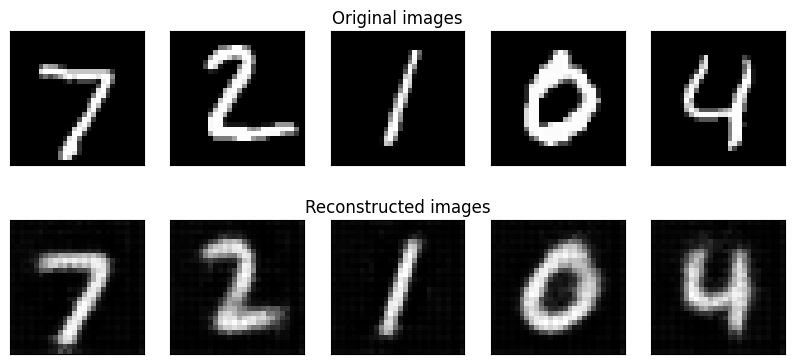

	 partial train loss (single batch): 9164.339844
	 partial train loss (single batch): 8920.869141
	 partial train loss (single batch): 8985.479492
	 partial train loss (single batch): 8968.257812
	 partial train loss (single batch): 9161.761719
	 partial train loss (single batch): 9082.517578
	 partial train loss (single batch): 8931.800781
	 partial train loss (single batch): 9471.181641
	 partial train loss (single batch): 8810.636719
	 partial train loss (single batch): 9069.171875
	 partial train loss (single batch): 8625.955078
	 partial train loss (single batch): 8843.990234
	 partial train loss (single batch): 9159.652344
	 partial train loss (single batch): 9280.559570
	 partial train loss (single batch): 8784.712891
	 partial train loss (single batch): 8847.673828
	 partial train loss (single batch): 9306.307617
	 partial train loss (single batch): 8847.233398
	 partial train loss (single batch): 8932.318359
	 partial train loss (single batch): 9022.162109
	 partial train loss

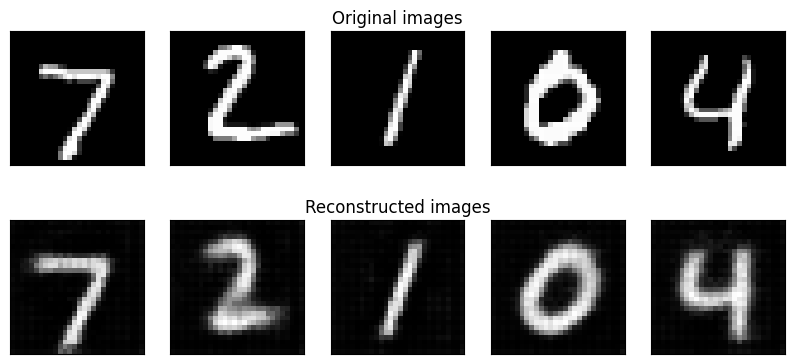

	 partial train loss (single batch): 9045.486328
	 partial train loss (single batch): 8740.859375
	 partial train loss (single batch): 8827.897461
	 partial train loss (single batch): 8808.799805
	 partial train loss (single batch): 9075.181641
	 partial train loss (single batch): 8930.907227
	 partial train loss (single batch): 8864.807617
	 partial train loss (single batch): 9359.892578
	 partial train loss (single batch): 8712.093750
	 partial train loss (single batch): 8995.478516
	 partial train loss (single batch): 8552.416992
	 partial train loss (single batch): 8744.292969
	 partial train loss (single batch): 8975.624023
	 partial train loss (single batch): 9226.818359
	 partial train loss (single batch): 8697.560547
	 partial train loss (single batch): 8783.819336
	 partial train loss (single batch): 9276.317383
	 partial train loss (single batch): 8761.449219
	 partial train loss (single batch): 8969.259766
	 partial train loss (single batch): 8838.707031
	 partial train loss

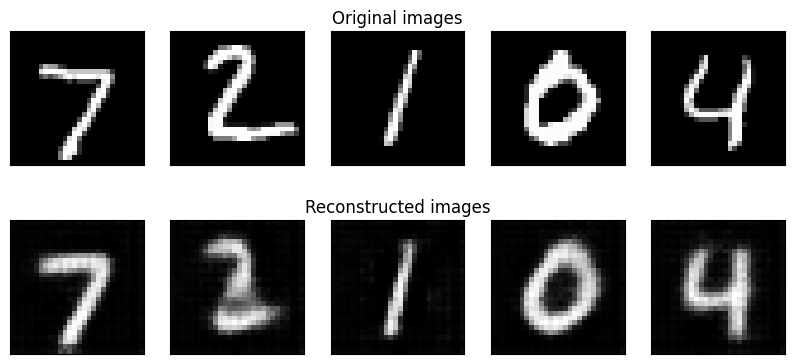

	 partial train loss (single batch): 9042.162109
	 partial train loss (single batch): 8765.130859
	 partial train loss (single batch): 8722.443359
	 partial train loss (single batch): 8741.138672
	 partial train loss (single batch): 8949.173828
	 partial train loss (single batch): 8885.075195
	 partial train loss (single batch): 8759.625000
	 partial train loss (single batch): 9288.353516
	 partial train loss (single batch): 8635.356445
	 partial train loss (single batch): 8946.908203
	 partial train loss (single batch): 8509.455078
	 partial train loss (single batch): 8744.988281
	 partial train loss (single batch): 8897.987305
	 partial train loss (single batch): 9129.953125
	 partial train loss (single batch): 8594.633789
	 partial train loss (single batch): 8695.265625
	 partial train loss (single batch): 9168.822266
	 partial train loss (single batch): 8637.361328
	 partial train loss (single batch): 8877.792969
	 partial train loss (single batch): 8835.594727
	 partial train loss

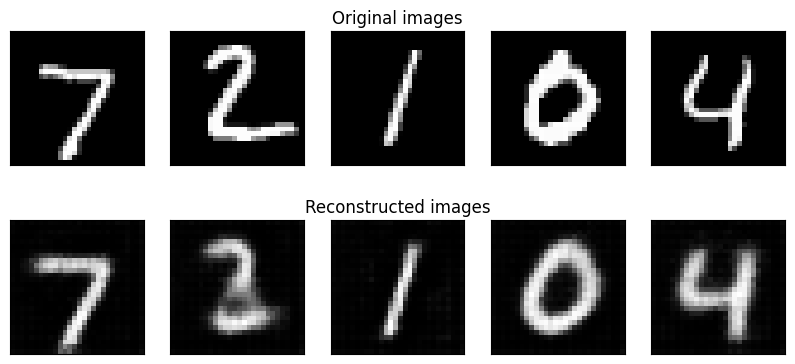

	 partial train loss (single batch): 8847.464844
	 partial train loss (single batch): 8642.335938
	 partial train loss (single batch): 8659.296875
	 partial train loss (single batch): 8668.061523
	 partial train loss (single batch): 9003.759766
	 partial train loss (single batch): 8794.970703
	 partial train loss (single batch): 8746.556641
	 partial train loss (single batch): 9201.068359
	 partial train loss (single batch): 8611.430664
	 partial train loss (single batch): 8898.441406
	 partial train loss (single batch): 8398.710938
	 partial train loss (single batch): 8633.720703
	 partial train loss (single batch): 8783.574219
	 partial train loss (single batch): 9141.705078
	 partial train loss (single batch): 8637.823242
	 partial train loss (single batch): 8613.615234
	 partial train loss (single batch): 9080.261719
	 partial train loss (single batch): 8525.371094
	 partial train loss (single batch): 8751.724609
	 partial train loss (single batch): 8725.244141
	 partial train loss

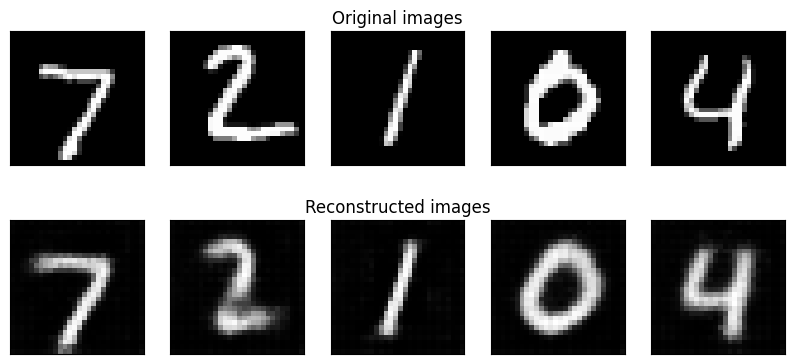

	 partial train loss (single batch): 8886.688477
	 partial train loss (single batch): 8644.179688
	 partial train loss (single batch): 8533.531250
	 partial train loss (single batch): 8540.951172
	 partial train loss (single batch): 8881.594727
	 partial train loss (single batch): 8849.454102
	 partial train loss (single batch): 8693.466797
	 partial train loss (single batch): 9127.903320
	 partial train loss (single batch): 8583.540039
	 partial train loss (single batch): 8777.353516
	 partial train loss (single batch): 8333.818359
	 partial train loss (single batch): 8564.547852
	 partial train loss (single batch): 8799.290039
	 partial train loss (single batch): 9028.646484
	 partial train loss (single batch): 8482.361328
	 partial train loss (single batch): 8498.014648
	 partial train loss (single batch): 9038.896484
	 partial train loss (single batch): 8529.883789
	 partial train loss (single batch): 8681.984375
	 partial train loss (single batch): 8681.161133
	 partial train loss

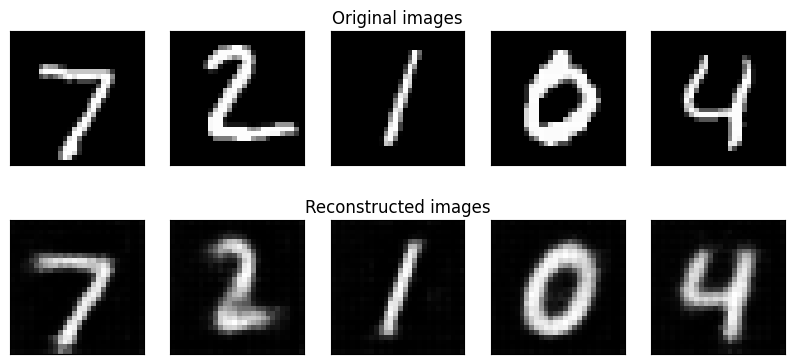

	 partial train loss (single batch): 8907.403320
	 partial train loss (single batch): 8622.385742
	 partial train loss (single batch): 8538.947266
	 partial train loss (single batch): 8557.273438
	 partial train loss (single batch): 8841.356445
	 partial train loss (single batch): 8720.150391
	 partial train loss (single batch): 8620.238281
	 partial train loss (single batch): 9116.713867
	 partial train loss (single batch): 8527.863281
	 partial train loss (single batch): 8735.670898
	 partial train loss (single batch): 8345.800781
	 partial train loss (single batch): 8546.643555
	 partial train loss (single batch): 8675.473633
	 partial train loss (single batch): 8988.074219
	 partial train loss (single batch): 8518.818359
	 partial train loss (single batch): 8556.746094
	 partial train loss (single batch): 9032.277344
	 partial train loss (single batch): 8504.432617
	 partial train loss (single batch): 8703.282227
	 partial train loss (single batch): 8627.580078
	 partial train loss

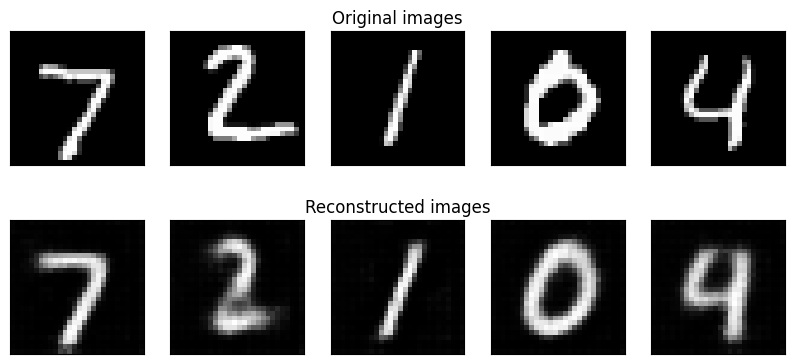

	 partial train loss (single batch): 8881.405273
	 partial train loss (single batch): 8620.265625
	 partial train loss (single batch): 8473.816406
	 partial train loss (single batch): 8587.333984
	 partial train loss (single batch): 8790.056641
	 partial train loss (single batch): 8741.558594
	 partial train loss (single batch): 8597.456055
	 partial train loss (single batch): 9120.435547
	 partial train loss (single batch): 8481.878906
	 partial train loss (single batch): 8671.126953
	 partial train loss (single batch): 8301.497070
	 partial train loss (single batch): 8471.765625
	 partial train loss (single batch): 8658.478516
	 partial train loss (single batch): 9009.445312
	 partial train loss (single batch): 8389.750000
	 partial train loss (single batch): 8597.486328
	 partial train loss (single batch): 8930.087891
	 partial train loss (single batch): 8405.612305
	 partial train loss (single batch): 8568.442383
	 partial train loss (single batch): 8688.807617
	 partial train loss

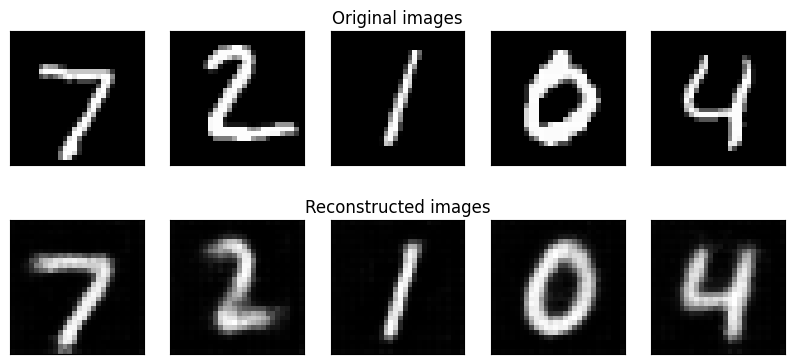

	 partial train loss (single batch): 8754.260742
	 partial train loss (single batch): 8517.998047
	 partial train loss (single batch): 8428.541992
	 partial train loss (single batch): 8487.574219
	 partial train loss (single batch): 8791.755859
	 partial train loss (single batch): 8698.667969
	 partial train loss (single batch): 8568.885742
	 partial train loss (single batch): 9006.662109
	 partial train loss (single batch): 8379.134766
	 partial train loss (single batch): 8632.370117
	 partial train loss (single batch): 8263.546875
	 partial train loss (single batch): 8455.126953
	 partial train loss (single batch): 8640.767578
	 partial train loss (single batch): 8900.910156
	 partial train loss (single batch): 8432.468750
	 partial train loss (single batch): 8440.581055
	 partial train loss (single batch): 8942.207031
	 partial train loss (single batch): 8446.977539
	 partial train loss (single batch): 8618.121094
	 partial train loss (single batch): 8613.353516
	 partial train loss

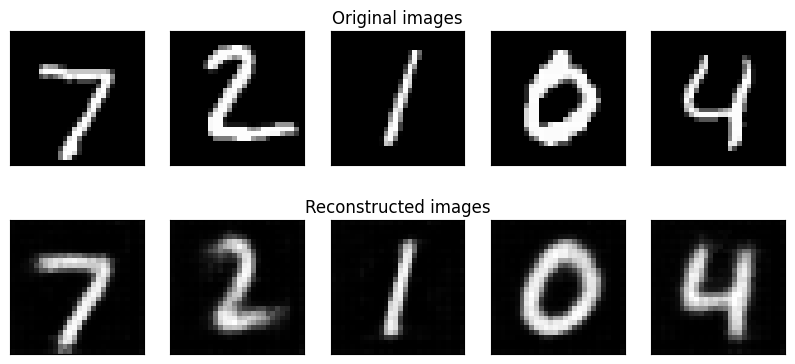

	 partial train loss (single batch): 8722.615234
	 partial train loss (single batch): 8514.544922
	 partial train loss (single batch): 8392.087891
	 partial train loss (single batch): 8477.724609
	 partial train loss (single batch): 8668.707031
	 partial train loss (single batch): 8656.125977
	 partial train loss (single batch): 8588.015625
	 partial train loss (single batch): 8953.205078
	 partial train loss (single batch): 8289.812500
	 partial train loss (single batch): 8608.195312
	 partial train loss (single batch): 8229.273438
	 partial train loss (single batch): 8501.314453
	 partial train loss (single batch): 8559.724609
	 partial train loss (single batch): 8958.434570
	 partial train loss (single batch): 8356.809570
	 partial train loss (single batch): 8417.185547
	 partial train loss (single batch): 8835.876953
	 partial train loss (single batch): 8391.598633
	 partial train loss (single batch): 8565.231445
	 partial train loss (single batch): 8595.855469
	 partial train loss

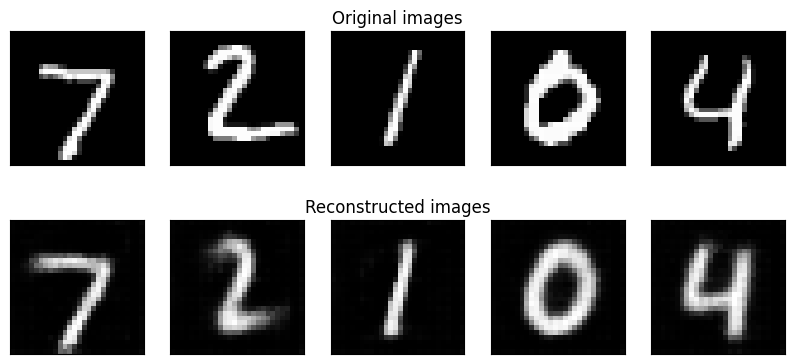

	 partial train loss (single batch): 8768.022461
	 partial train loss (single batch): 8471.868164
	 partial train loss (single batch): 8405.904297
	 partial train loss (single batch): 8428.447266
	 partial train loss (single batch): 8704.584961
	 partial train loss (single batch): 8616.329102
	 partial train loss (single batch): 8486.074219
	 partial train loss (single batch): 8973.123047
	 partial train loss (single batch): 8413.535156
	 partial train loss (single batch): 8503.273438
	 partial train loss (single batch): 8199.783203
	 partial train loss (single batch): 8360.429688
	 partial train loss (single batch): 8585.416016
	 partial train loss (single batch): 8860.621094
	 partial train loss (single batch): 8301.619141
	 partial train loss (single batch): 8451.674805
	 partial train loss (single batch): 8896.357422
	 partial train loss (single batch): 8346.445312
	 partial train loss (single batch): 8523.567383
	 partial train loss (single batch): 8473.021484
	 partial train loss

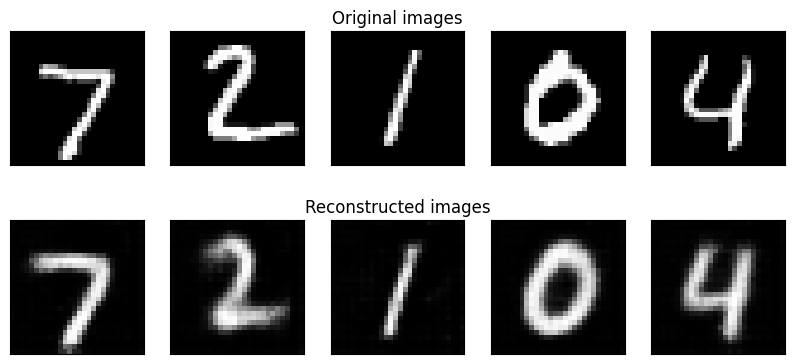

	 partial train loss (single batch): 8648.930664
	 partial train loss (single batch): 8401.737305
	 partial train loss (single batch): 8368.608398
	 partial train loss (single batch): 8314.737305
	 partial train loss (single batch): 8680.751953
	 partial train loss (single batch): 8538.410156
	 partial train loss (single batch): 8482.212891
	 partial train loss (single batch): 8928.781250
	 partial train loss (single batch): 8308.357422
	 partial train loss (single batch): 8573.363281
	 partial train loss (single batch): 8208.957031
	 partial train loss (single batch): 8454.017578
	 partial train loss (single batch): 8501.242188
	 partial train loss (single batch): 8815.341797
	 partial train loss (single batch): 8307.243164
	 partial train loss (single batch): 8423.995117
	 partial train loss (single batch): 8859.083984
	 partial train loss (single batch): 8311.394531
	 partial train loss (single batch): 8534.388672
	 partial train loss (single batch): 8516.267578
	 partial train loss

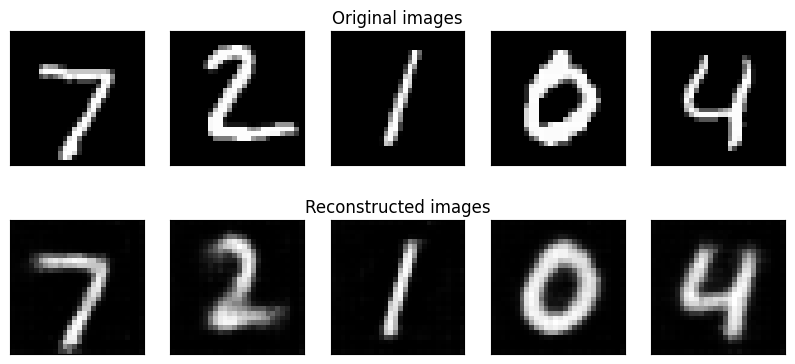

	 partial train loss (single batch): 8643.646484
	 partial train loss (single batch): 8464.301758
	 partial train loss (single batch): 8338.843750
	 partial train loss (single batch): 8422.995117
	 partial train loss (single batch): 8674.125000
	 partial train loss (single batch): 8644.750977
	 partial train loss (single batch): 8467.276367
	 partial train loss (single batch): 8988.837891
	 partial train loss (single batch): 8229.288086
	 partial train loss (single batch): 8521.976562
	 partial train loss (single batch): 8200.468750
	 partial train loss (single batch): 8420.075195
	 partial train loss (single batch): 8488.191406
	 partial train loss (single batch): 8772.025391
	 partial train loss (single batch): 8280.363281
	 partial train loss (single batch): 8420.367188
	 partial train loss (single batch): 8863.399414
	 partial train loss (single batch): 8252.912109
	 partial train loss (single batch): 8462.949219
	 partial train loss (single batch): 8500.304688
	 partial train loss

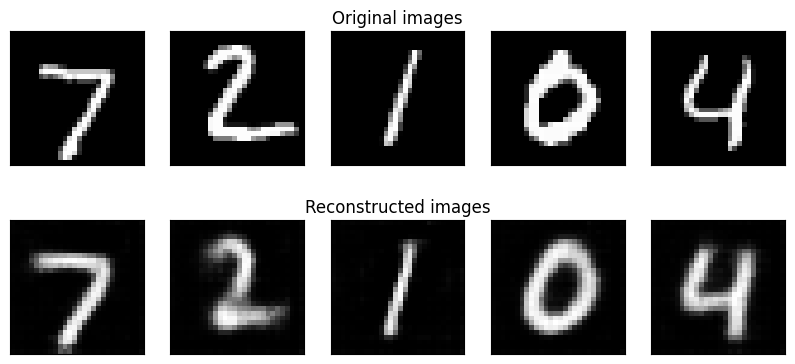

	 partial train loss (single batch): 8570.419922
	 partial train loss (single batch): 8409.027344
	 partial train loss (single batch): 8328.042969
	 partial train loss (single batch): 8335.880859
	 partial train loss (single batch): 8702.475586
	 partial train loss (single batch): 8519.656250
	 partial train loss (single batch): 8422.941406
	 partial train loss (single batch): 8787.142578
	 partial train loss (single batch): 8215.208008
	 partial train loss (single batch): 8521.557617
	 partial train loss (single batch): 8123.837402
	 partial train loss (single batch): 8379.908203
	 partial train loss (single batch): 8409.772461
	 partial train loss (single batch): 8771.554688
	 partial train loss (single batch): 8255.834961
	 partial train loss (single batch): 8352.219727
	 partial train loss (single batch): 8743.938477
	 partial train loss (single batch): 8308.671875
	 partial train loss (single batch): 8498.439453
	 partial train loss (single batch): 8466.764648
	 partial train loss

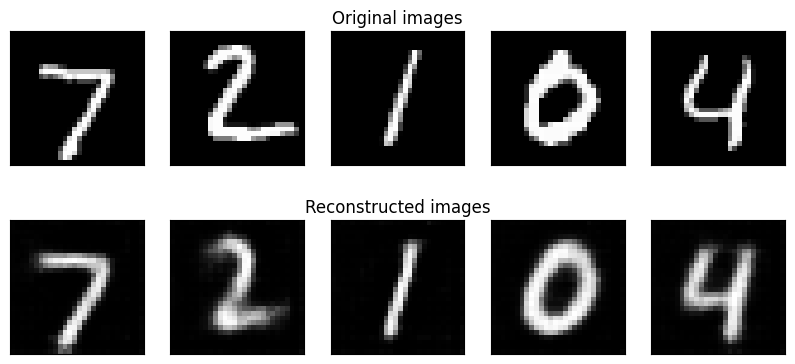

	 partial train loss (single batch): 8684.135742
	 partial train loss (single batch): 8409.247070
	 partial train loss (single batch): 8274.671875
	 partial train loss (single batch): 8321.498047
	 partial train loss (single batch): 8669.949219
	 partial train loss (single batch): 8445.193359
	 partial train loss (single batch): 8433.695312
	 partial train loss (single batch): 8855.738281
	 partial train loss (single batch): 8176.480469
	 partial train loss (single batch): 8442.324219
	 partial train loss (single batch): 8152.685547
	 partial train loss (single batch): 8342.404297
	 partial train loss (single batch): 8541.455078
	 partial train loss (single batch): 8817.248047
	 partial train loss (single batch): 8262.039062
	 partial train loss (single batch): 8305.929688
	 partial train loss (single batch): 8823.630859
	 partial train loss (single batch): 8219.484375
	 partial train loss (single batch): 8437.459961
	 partial train loss (single batch): 8329.326172
	 partial train loss

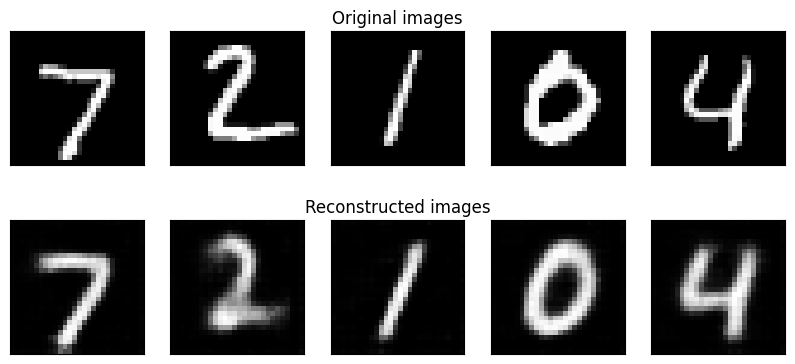

	 partial train loss (single batch): 8635.059570
	 partial train loss (single batch): 8391.350586
	 partial train loss (single batch): 8338.821289
	 partial train loss (single batch): 8357.128906
	 partial train loss (single batch): 8570.233398
	 partial train loss (single batch): 8473.070312
	 partial train loss (single batch): 8404.750000
	 partial train loss (single batch): 8795.455078
	 partial train loss (single batch): 8308.083984
	 partial train loss (single batch): 8530.216797
	 partial train loss (single batch): 8138.928711
	 partial train loss (single batch): 8321.833984
	 partial train loss (single batch): 8447.806641
	 partial train loss (single batch): 8674.537109
	 partial train loss (single batch): 8199.871094
	 partial train loss (single batch): 8329.281250
	 partial train loss (single batch): 8754.550781
	 partial train loss (single batch): 8271.458008
	 partial train loss (single batch): 8440.728516
	 partial train loss (single batch): 8417.119141
	 partial train loss

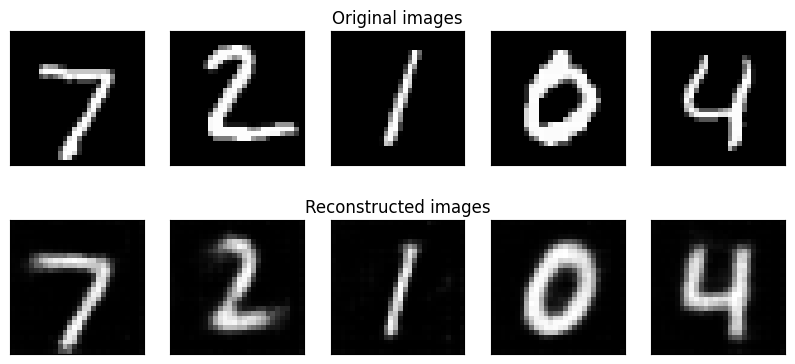

	 partial train loss (single batch): 8594.154297
	 partial train loss (single batch): 8341.609375
	 partial train loss (single batch): 8301.587891
	 partial train loss (single batch): 8274.759766
	 partial train loss (single batch): 8630.831055
	 partial train loss (single batch): 8370.376953
	 partial train loss (single batch): 8413.269531
	 partial train loss (single batch): 8808.925781
	 partial train loss (single batch): 8177.184082
	 partial train loss (single batch): 8469.746094
	 partial train loss (single batch): 8136.893066
	 partial train loss (single batch): 8327.281250
	 partial train loss (single batch): 8428.538086
	 partial train loss (single batch): 8670.433594
	 partial train loss (single batch): 8213.328125
	 partial train loss (single batch): 8254.880859
	 partial train loss (single batch): 8798.073242
	 partial train loss (single batch): 8219.460938
	 partial train loss (single batch): 8351.552734
	 partial train loss (single batch): 8357.832031
	 partial train loss

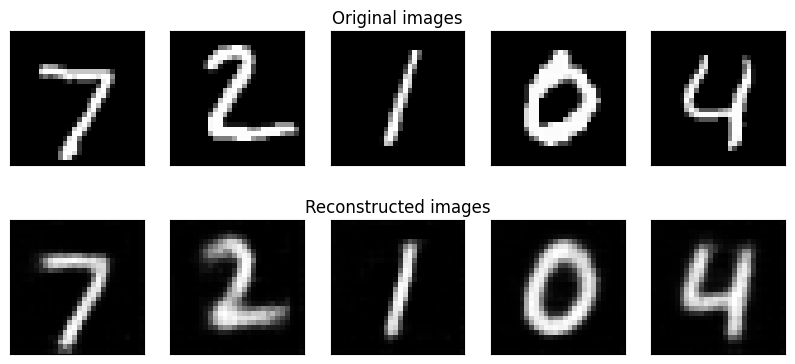

	 partial train loss (single batch): 8571.363281
	 partial train loss (single batch): 8260.548828
	 partial train loss (single batch): 8294.689453
	 partial train loss (single batch): 8300.994141
	 partial train loss (single batch): 8622.185547
	 partial train loss (single batch): 8497.502930
	 partial train loss (single batch): 8375.458008
	 partial train loss (single batch): 8744.789062
	 partial train loss (single batch): 8148.296875
	 partial train loss (single batch): 8359.531250
	 partial train loss (single batch): 8141.365723
	 partial train loss (single batch): 8234.649414
	 partial train loss (single batch): 8478.657227
	 partial train loss (single batch): 8680.019531
	 partial train loss (single batch): 8203.673828
	 partial train loss (single batch): 8254.644531
	 partial train loss (single batch): 8717.092773
	 partial train loss (single batch): 8166.041016
	 partial train loss (single batch): 8405.320312
	 partial train loss (single batch): 8254.006836
	 partial train loss

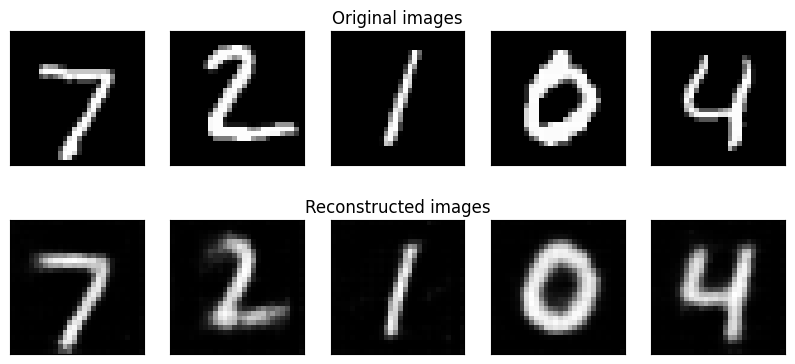

	 partial train loss (single batch): 8481.287109
	 partial train loss (single batch): 8404.523438
	 partial train loss (single batch): 8272.476562
	 partial train loss (single batch): 8210.420898
	 partial train loss (single batch): 8558.456055
	 partial train loss (single batch): 8422.740234
	 partial train loss (single batch): 8299.556641
	 partial train loss (single batch): 8763.886719
	 partial train loss (single batch): 8170.190918
	 partial train loss (single batch): 8408.160156
	 partial train loss (single batch): 8122.612305
	 partial train loss (single batch): 8328.414062
	 partial train loss (single batch): 8373.937500
	 partial train loss (single batch): 8728.933594
	 partial train loss (single batch): 8190.862793
	 partial train loss (single batch): 8225.223633
	 partial train loss (single batch): 8779.773438
	 partial train loss (single batch): 8175.276367
	 partial train loss (single batch): 8361.119141
	 partial train loss (single batch): 8312.416016
	 partial train loss

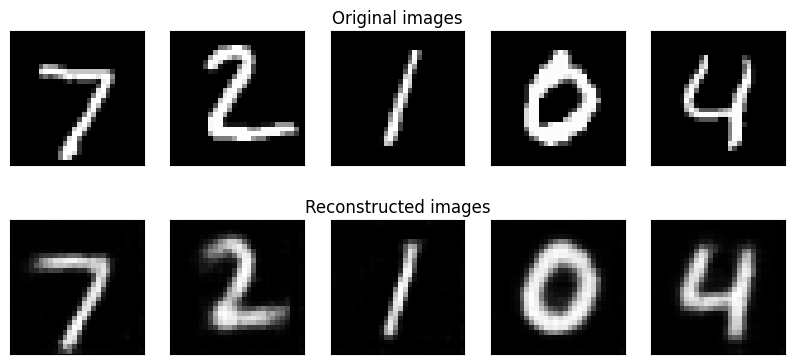

	 partial train loss (single batch): 8548.945312
	 partial train loss (single batch): 8261.976562
	 partial train loss (single batch): 8194.402344
	 partial train loss (single batch): 8220.435547
	 partial train loss (single batch): 8602.182617
	 partial train loss (single batch): 8344.025391
	 partial train loss (single batch): 8296.403320
	 partial train loss (single batch): 8722.503906
	 partial train loss (single batch): 8123.714844
	 partial train loss (single batch): 8328.250000
	 partial train loss (single batch): 8112.378418
	 partial train loss (single batch): 8240.567383
	 partial train loss (single batch): 8359.556641
	 partial train loss (single batch): 8709.990234
	 partial train loss (single batch): 8162.406250
	 partial train loss (single batch): 8242.950195
	 partial train loss (single batch): 8679.683594
	 partial train loss (single batch): 8180.241211
	 partial train loss (single batch): 8472.379883
	 partial train loss (single batch): 8324.629883
	 partial train loss

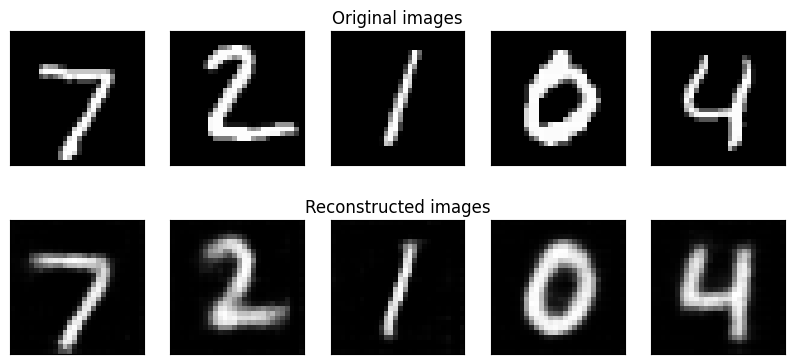

	 partial train loss (single batch): 8566.366211
	 partial train loss (single batch): 8276.525391
	 partial train loss (single batch): 8219.714844
	 partial train loss (single batch): 8237.459961
	 partial train loss (single batch): 8488.759766
	 partial train loss (single batch): 8352.197266
	 partial train loss (single batch): 8293.671875
	 partial train loss (single batch): 8714.492188
	 partial train loss (single batch): 8141.342773
	 partial train loss (single batch): 8378.074219
	 partial train loss (single batch): 8091.514648
	 partial train loss (single batch): 8231.663086
	 partial train loss (single batch): 8387.586914
	 partial train loss (single batch): 8582.524414
	 partial train loss (single batch): 8135.570312
	 partial train loss (single batch): 8232.007812
	 partial train loss (single batch): 8687.891602
	 partial train loss (single batch): 8100.764160
	 partial train loss (single batch): 8349.194336
	 partial train loss (single batch): 8335.829102
	 partial train loss

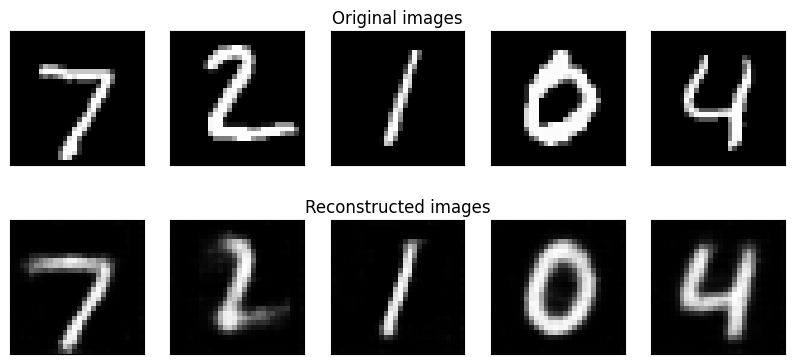

	 partial train loss (single batch): 8535.785156
	 partial train loss (single batch): 8270.599609
	 partial train loss (single batch): 8164.910645
	 partial train loss (single batch): 8255.898438
	 partial train loss (single batch): 8525.235352
	 partial train loss (single batch): 8392.955078
	 partial train loss (single batch): 8338.978516
	 partial train loss (single batch): 8664.218750
	 partial train loss (single batch): 8124.317383
	 partial train loss (single batch): 8315.693359
	 partial train loss (single batch): 8037.976562
	 partial train loss (single batch): 8243.569336
	 partial train loss (single batch): 8336.775391
	 partial train loss (single batch): 8548.504883
	 partial train loss (single batch): 8147.710449
	 partial train loss (single batch): 8248.253906
	 partial train loss (single batch): 8758.863281
	 partial train loss (single batch): 8152.149414
	 partial train loss (single batch): 8262.700195
	 partial train loss (single batch): 8322.464844
	 partial train loss

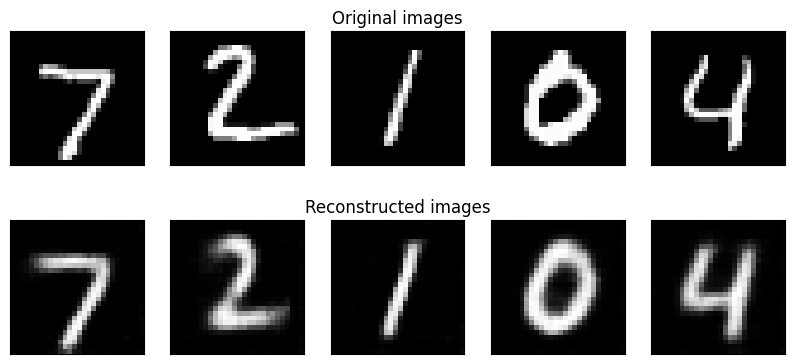

	 partial train loss (single batch): 8556.000977
	 partial train loss (single batch): 8247.089844
	 partial train loss (single batch): 8216.804688
	 partial train loss (single batch): 8258.476562
	 partial train loss (single batch): 8486.040039
	 partial train loss (single batch): 8393.140625
	 partial train loss (single batch): 8299.812500
	 partial train loss (single batch): 8671.445312
	 partial train loss (single batch): 8086.196777
	 partial train loss (single batch): 8274.292969
	 partial train loss (single batch): 7972.672852
	 partial train loss (single batch): 8209.911133
	 partial train loss (single batch): 8337.384766
	 partial train loss (single batch): 8547.803711
	 partial train loss (single batch): 8065.432617
	 partial train loss (single batch): 8183.897949
	 partial train loss (single batch): 8672.041992
	 partial train loss (single batch): 8067.929688
	 partial train loss (single batch): 8286.380859
	 partial train loss (single batch): 8268.855469
	 partial train loss

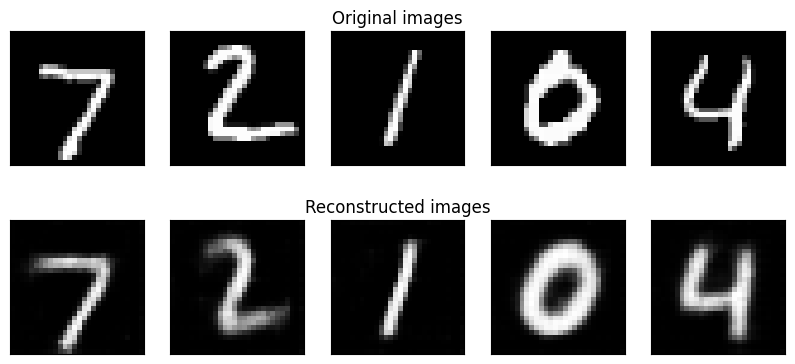

	 partial train loss (single batch): 8539.788086
	 partial train loss (single batch): 8300.824219
	 partial train loss (single batch): 8175.068848
	 partial train loss (single batch): 8159.829590
	 partial train loss (single batch): 8473.106445
	 partial train loss (single batch): 8315.417969
	 partial train loss (single batch): 8334.196289
	 partial train loss (single batch): 8674.104492
	 partial train loss (single batch): 8047.227539
	 partial train loss (single batch): 8314.800781
	 partial train loss (single batch): 8085.383789
	 partial train loss (single batch): 8222.236328
	 partial train loss (single batch): 8355.405273
	 partial train loss (single batch): 8608.814453
	 partial train loss (single batch): 8038.067383
	 partial train loss (single batch): 8174.098145
	 partial train loss (single batch): 8666.380859
	 partial train loss (single batch): 8176.064453
	 partial train loss (single batch): 8328.929688
	 partial train loss (single batch): 8372.943359
	 partial train loss

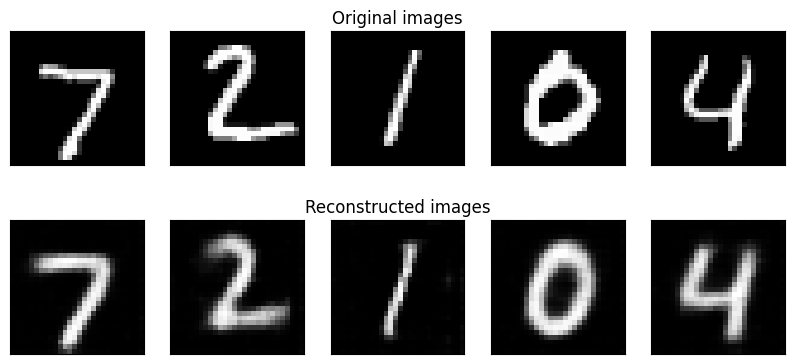

	 partial train loss (single batch): 8460.603516
	 partial train loss (single batch): 8270.869141
	 partial train loss (single batch): 8148.719727
	 partial train loss (single batch): 8139.867188
	 partial train loss (single batch): 8479.245117
	 partial train loss (single batch): 8362.998047
	 partial train loss (single batch): 8265.519531
	 partial train loss (single batch): 8728.115234
	 partial train loss (single batch): 8055.072266
	 partial train loss (single batch): 8247.402344
	 partial train loss (single batch): 8065.019043
	 partial train loss (single batch): 8185.893555
	 partial train loss (single batch): 8305.780273
	 partial train loss (single batch): 8504.157227
	 partial train loss (single batch): 8083.986328
	 partial train loss (single batch): 8197.246094
	 partial train loss (single batch): 8612.349609
	 partial train loss (single batch): 8049.181641
	 partial train loss (single batch): 8229.744141
	 partial train loss (single batch): 8209.654297
	 partial train loss

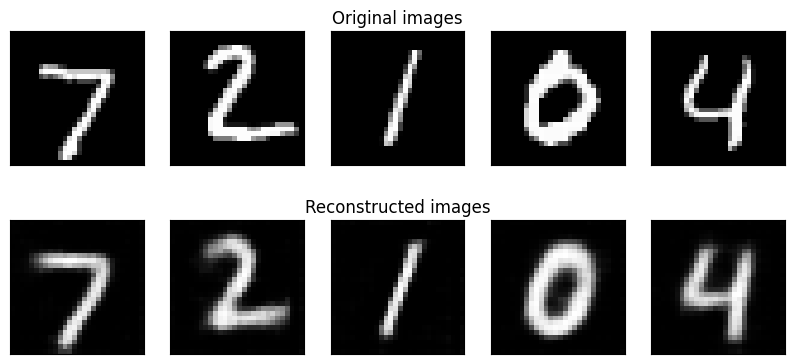

	 partial train loss (single batch): 8464.833008
	 partial train loss (single batch): 8241.311523
	 partial train loss (single batch): 8186.498047
	 partial train loss (single batch): 8196.046875
	 partial train loss (single batch): 8534.176758
	 partial train loss (single batch): 8371.264648
	 partial train loss (single batch): 8271.509766
	 partial train loss (single batch): 8567.022461
	 partial train loss (single batch): 8092.006348
	 partial train loss (single batch): 8319.248047
	 partial train loss (single batch): 8053.557617
	 partial train loss (single batch): 8147.026367
	 partial train loss (single batch): 8282.598633
	 partial train loss (single batch): 8548.826172
	 partial train loss (single batch): 8034.847168
	 partial train loss (single batch): 8160.672852
	 partial train loss (single batch): 8698.762695
	 partial train loss (single batch): 8073.136230
	 partial train loss (single batch): 8292.304688
	 partial train loss (single batch): 8272.676758
	 partial train loss

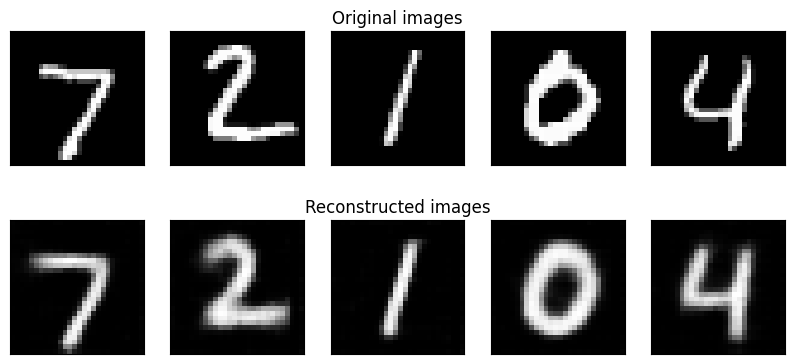

	 partial train loss (single batch): 8443.906250
	 partial train loss (single batch): 8235.932617
	 partial train loss (single batch): 8225.270508
	 partial train loss (single batch): 8147.357422
	 partial train loss (single batch): 8487.648438
	 partial train loss (single batch): 8326.048828
	 partial train loss (single batch): 8206.148438
	 partial train loss (single batch): 8575.195312
	 partial train loss (single batch): 8039.754883
	 partial train loss (single batch): 8368.619141
	 partial train loss (single batch): 8006.773438
	 partial train loss (single batch): 8197.868164
	 partial train loss (single batch): 8235.088867
	 partial train loss (single batch): 8507.000000
	 partial train loss (single batch): 8085.078125
	 partial train loss (single batch): 8154.199707
	 partial train loss (single batch): 8595.757812
	 partial train loss (single batch): 8030.386230
	 partial train loss (single batch): 8278.819336
	 partial train loss (single batch): 8241.666016
	 partial train loss

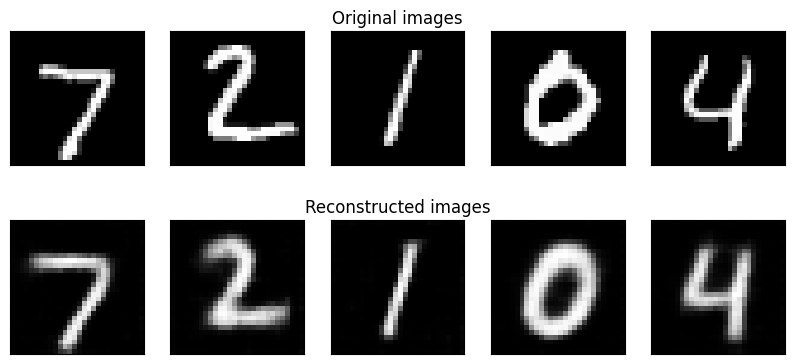

	 partial train loss (single batch): 8463.529297
	 partial train loss (single batch): 8180.444824
	 partial train loss (single batch): 8169.765625
	 partial train loss (single batch): 8118.298828
	 partial train loss (single batch): 8490.146484
	 partial train loss (single batch): 8335.827148
	 partial train loss (single batch): 8280.685547
	 partial train loss (single batch): 8633.248047
	 partial train loss (single batch): 8127.832031
	 partial train loss (single batch): 8258.041016
	 partial train loss (single batch): 7975.386719
	 partial train loss (single batch): 8109.663574
	 partial train loss (single batch): 8295.454102
	 partial train loss (single batch): 8474.291016
	 partial train loss (single batch): 8015.383789
	 partial train loss (single batch): 8183.047852
	 partial train loss (single batch): 8573.687500
	 partial train loss (single batch): 8032.061523
	 partial train loss (single batch): 8251.668945
	 partial train loss (single batch): 8211.441406
	 partial train loss

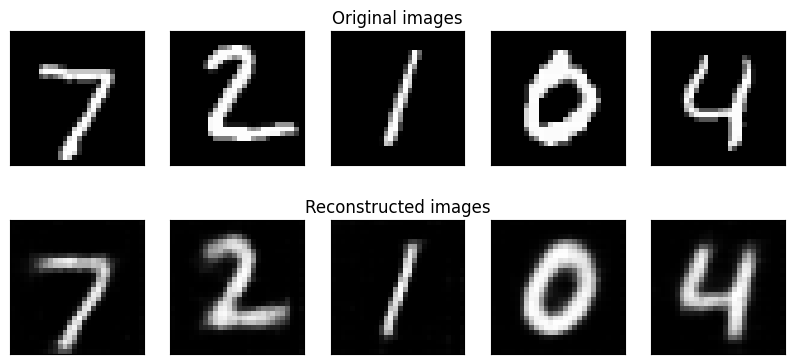

	 partial train loss (single batch): 8467.017578
	 partial train loss (single batch): 8265.518555
	 partial train loss (single batch): 8096.411133
	 partial train loss (single batch): 8127.658203
	 partial train loss (single batch): 8524.697266
	 partial train loss (single batch): 8285.601562
	 partial train loss (single batch): 8221.366211
	 partial train loss (single batch): 8647.726562
	 partial train loss (single batch): 8028.358398
	 partial train loss (single batch): 8269.310547
	 partial train loss (single batch): 8019.137207
	 partial train loss (single batch): 8184.723633
	 partial train loss (single batch): 8286.069336
	 partial train loss (single batch): 8470.074219
	 partial train loss (single batch): 7990.413574
	 partial train loss (single batch): 8112.469727
	 partial train loss (single batch): 8618.129883
	 partial train loss (single batch): 7965.990234
	 partial train loss (single batch): 8231.278320
	 partial train loss (single batch): 8187.102051
	 partial train loss

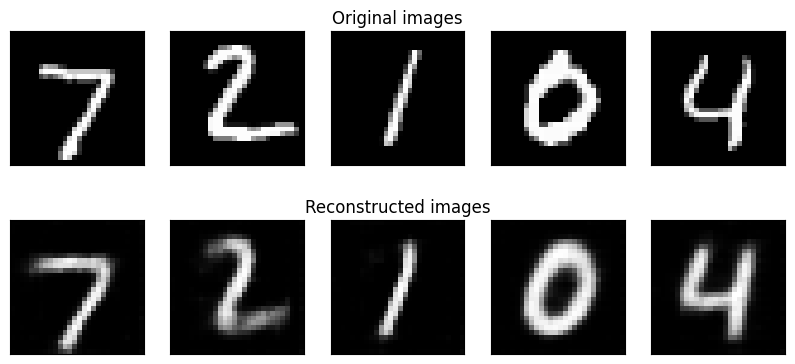

	 partial train loss (single batch): 8439.628906
	 partial train loss (single batch): 8195.864258
	 partial train loss (single batch): 8138.932129
	 partial train loss (single batch): 8192.949219
	 partial train loss (single batch): 8476.889648
	 partial train loss (single batch): 8243.416992
	 partial train loss (single batch): 8194.065430
	 partial train loss (single batch): 8557.989258
	 partial train loss (single batch): 8012.513672
	 partial train loss (single batch): 8195.424805
	 partial train loss (single batch): 7905.873047
	 partial train loss (single batch): 8163.874023
	 partial train loss (single batch): 8263.916992
	 partial train loss (single batch): 8535.070312
	 partial train loss (single batch): 8079.328125
	 partial train loss (single batch): 8118.358398
	 partial train loss (single batch): 8495.314453
	 partial train loss (single batch): 8013.054688
	 partial train loss (single batch): 8238.492188
	 partial train loss (single batch): 8247.125000
	 partial train loss

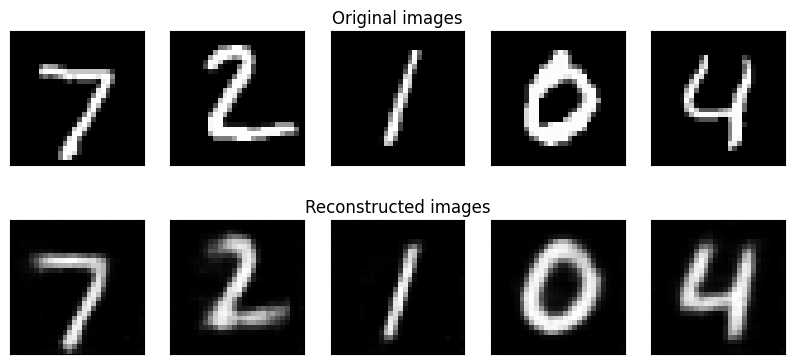

	 partial train loss (single batch): 8445.123047
	 partial train loss (single batch): 8251.765625
	 partial train loss (single batch): 8171.569336
	 partial train loss (single batch): 8168.129883
	 partial train loss (single batch): 8427.066406
	 partial train loss (single batch): 8275.871094
	 partial train loss (single batch): 8231.759766
	 partial train loss (single batch): 8642.652344
	 partial train loss (single batch): 7970.719238
	 partial train loss (single batch): 8208.809570
	 partial train loss (single batch): 7868.144531
	 partial train loss (single batch): 8092.760742
	 partial train loss (single batch): 8213.542969
	 partial train loss (single batch): 8462.794922
	 partial train loss (single batch): 8032.672363
	 partial train loss (single batch): 8162.379883
	 partial train loss (single batch): 8571.115234
	 partial train loss (single batch): 8034.674805
	 partial train loss (single batch): 8228.892578
	 partial train loss (single batch): 8137.936035
	 partial train loss

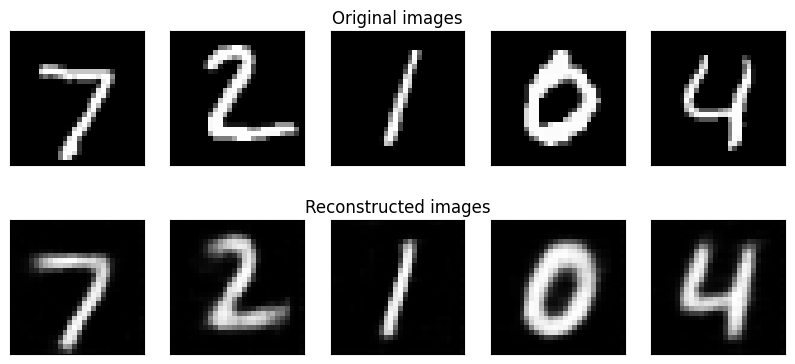

	 partial train loss (single batch): 8453.666016
	 partial train loss (single batch): 8218.607422
	 partial train loss (single batch): 8058.538086
	 partial train loss (single batch): 8105.423828
	 partial train loss (single batch): 8476.537109
	 partial train loss (single batch): 8353.141602
	 partial train loss (single batch): 8187.389160
	 partial train loss (single batch): 8622.205078
	 partial train loss (single batch): 7932.123047
	 partial train loss (single batch): 8176.025391
	 partial train loss (single batch): 8009.869141
	 partial train loss (single batch): 8085.066895
	 partial train loss (single batch): 8233.640625
	 partial train loss (single batch): 8414.110352
	 partial train loss (single batch): 8038.586914
	 partial train loss (single batch): 8080.751953
	 partial train loss (single batch): 8516.738281
	 partial train loss (single batch): 7958.110352
	 partial train loss (single batch): 8229.207031
	 partial train loss (single batch): 8153.369141
	 partial train loss

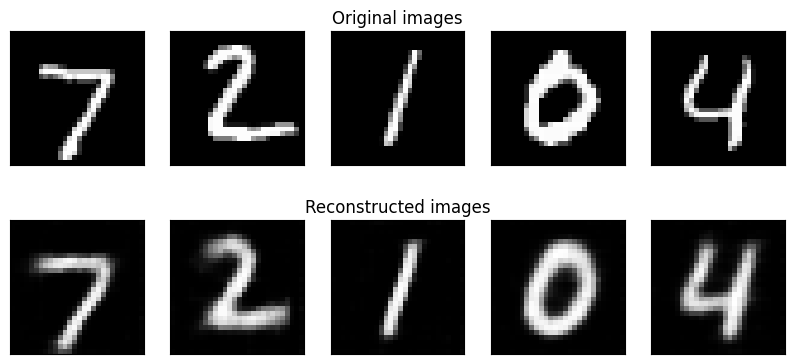

	 partial train loss (single batch): 8416.179688
	 partial train loss (single batch): 8179.312988
	 partial train loss (single batch): 8124.972168
	 partial train loss (single batch): 8090.509277
	 partial train loss (single batch): 8494.310547
	 partial train loss (single batch): 8293.544922
	 partial train loss (single batch): 8160.678711
	 partial train loss (single batch): 8619.161133
	 partial train loss (single batch): 8004.826172
	 partial train loss (single batch): 8173.259277
	 partial train loss (single batch): 7928.142578
	 partial train loss (single batch): 8133.045898
	 partial train loss (single batch): 8201.230469
	 partial train loss (single batch): 8395.091797
	 partial train loss (single batch): 7953.311523
	 partial train loss (single batch): 8070.275391
	 partial train loss (single batch): 8483.740234
	 partial train loss (single batch): 7943.517578
	 partial train loss (single batch): 8163.014648
	 partial train loss (single batch): 8176.572754
	 partial train loss

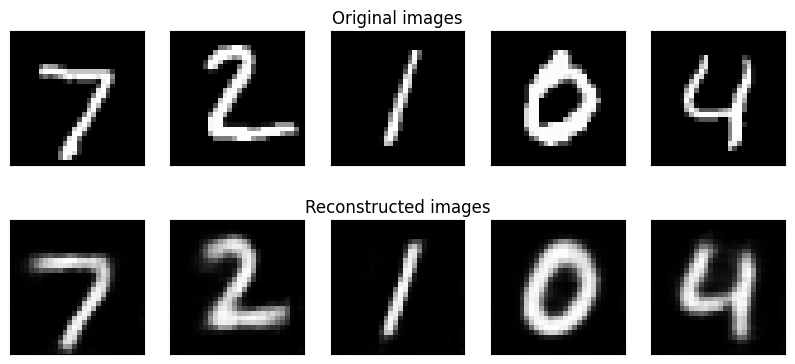

	 partial train loss (single batch): 8453.673828
	 partial train loss (single batch): 8277.853516
	 partial train loss (single batch): 8099.872559
	 partial train loss (single batch): 8138.072754
	 partial train loss (single batch): 8413.007812
	 partial train loss (single batch): 8266.099609
	 partial train loss (single batch): 8163.785645
	 partial train loss (single batch): 8546.726562
	 partial train loss (single batch): 8026.886719
	 partial train loss (single batch): 8143.740234
	 partial train loss (single batch): 7972.371582
	 partial train loss (single batch): 8160.655273
	 partial train loss (single batch): 8252.441406
	 partial train loss (single batch): 8414.615234
	 partial train loss (single batch): 7919.298828
	 partial train loss (single batch): 8088.623047
	 partial train loss (single batch): 8606.969727
	 partial train loss (single batch): 7989.364258
	 partial train loss (single batch): 8215.958008
	 partial train loss (single batch): 8166.256836
	 partial train loss

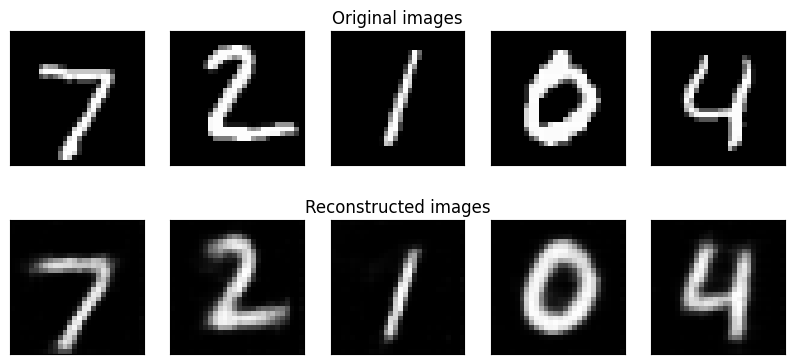

	 partial train loss (single batch): 8432.369141
	 partial train loss (single batch): 8177.123047
	 partial train loss (single batch): 8105.008301
	 partial train loss (single batch): 8102.899902
	 partial train loss (single batch): 8474.916016
	 partial train loss (single batch): 8309.255859
	 partial train loss (single batch): 8167.969727
	 partial train loss (single batch): 8553.202148
	 partial train loss (single batch): 7993.901367
	 partial train loss (single batch): 8163.608398
	 partial train loss (single batch): 7929.124512
	 partial train loss (single batch): 8075.092285
	 partial train loss (single batch): 8175.460938
	 partial train loss (single batch): 8451.390625
	 partial train loss (single batch): 7930.913574
	 partial train loss (single batch): 8067.443848
	 partial train loss (single batch): 8478.993164
	 partial train loss (single batch): 7961.155273
	 partial train loss (single batch): 8200.792969
	 partial train loss (single batch): 8225.207031
	 partial train loss

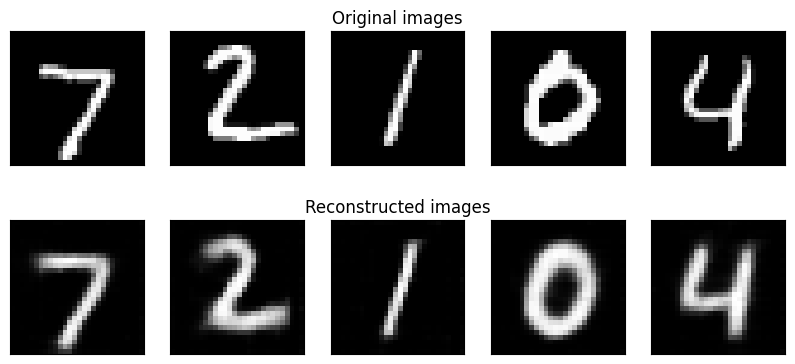

	 partial train loss (single batch): 8495.282227
	 partial train loss (single batch): 8206.489258
	 partial train loss (single batch): 8149.986328
	 partial train loss (single batch): 8082.187012
	 partial train loss (single batch): 8434.353516
	 partial train loss (single batch): 8206.208984
	 partial train loss (single batch): 8209.337891
	 partial train loss (single batch): 8516.001953
	 partial train loss (single batch): 7897.468750
	 partial train loss (single batch): 8177.141602
	 partial train loss (single batch): 7867.061035
	 partial train loss (single batch): 8091.494141
	 partial train loss (single batch): 8214.714844
	 partial train loss (single batch): 8362.441406
	 partial train loss (single batch): 7940.796875
	 partial train loss (single batch): 8050.111328
	 partial train loss (single batch): 8468.473633
	 partial train loss (single batch): 7985.581055
	 partial train loss (single batch): 8175.228516
	 partial train loss (single batch): 8167.403320
	 partial train loss

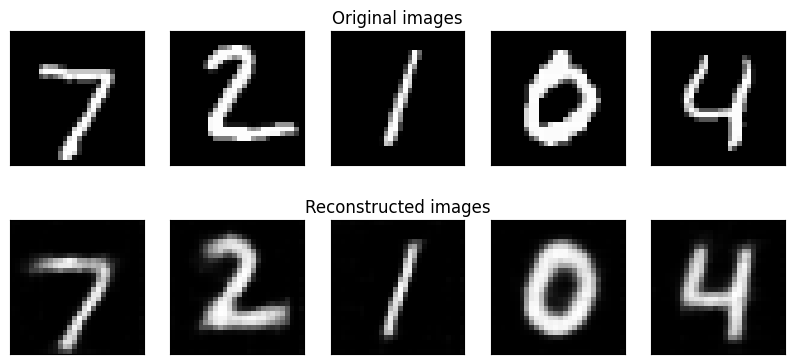

	 partial train loss (single batch): 8417.698242
	 partial train loss (single batch): 8295.197266
	 partial train loss (single batch): 8068.057617
	 partial train loss (single batch): 8135.428223
	 partial train loss (single batch): 8415.947266
	 partial train loss (single batch): 8319.457031
	 partial train loss (single batch): 8170.024414
	 partial train loss (single batch): 8552.491211
	 partial train loss (single batch): 7966.504395
	 partial train loss (single batch): 8157.740234
	 partial train loss (single batch): 7925.045898
	 partial train loss (single batch): 8110.949219
	 partial train loss (single batch): 8186.373047
	 partial train loss (single batch): 8373.267578
	 partial train loss (single batch): 7888.643555
	 partial train loss (single batch): 8132.234375
	 partial train loss (single batch): 8557.827148
	 partial train loss (single batch): 7976.383789
	 partial train loss (single batch): 8130.221191
	 partial train loss (single batch): 8152.675781
	 partial train loss

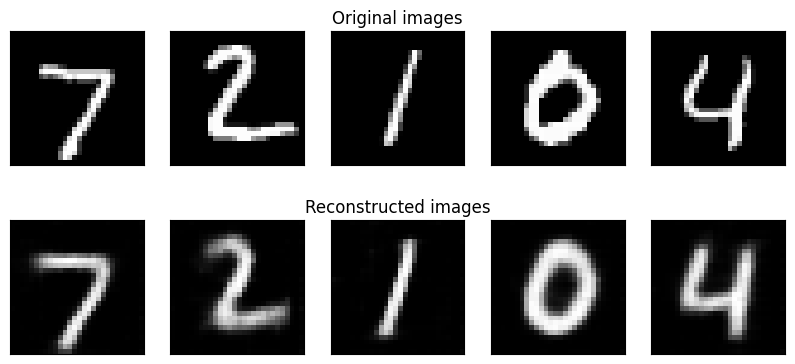

	 partial train loss (single batch): 8496.563477
	 partial train loss (single batch): 8145.062012
	 partial train loss (single batch): 8084.304199
	 partial train loss (single batch): 8034.533203
	 partial train loss (single batch): 8363.675781
	 partial train loss (single batch): 8268.492188
	 partial train loss (single batch): 8088.350098
	 partial train loss (single batch): 8534.896484
	 partial train loss (single batch): 7979.933594
	 partial train loss (single batch): 8206.912109
	 partial train loss (single batch): 7983.211914
	 partial train loss (single batch): 8042.131836
	 partial train loss (single batch): 8205.054688
	 partial train loss (single batch): 8368.224609
	 partial train loss (single batch): 7896.159668
	 partial train loss (single batch): 8065.692383
	 partial train loss (single batch): 8471.503906
	 partial train loss (single batch): 7946.087891
	 partial train loss (single batch): 8141.739746
	 partial train loss (single batch): 8061.742188
	 partial train loss

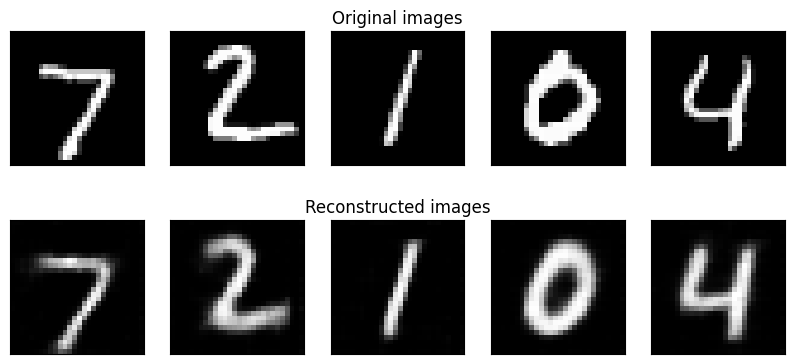

	 partial train loss (single batch): 8456.585938
	 partial train loss (single batch): 8173.131348
	 partial train loss (single batch): 8136.874023
	 partial train loss (single batch): 8125.286621
	 partial train loss (single batch): 8450.198242
	 partial train loss (single batch): 8260.205078
	 partial train loss (single batch): 8121.034180
	 partial train loss (single batch): 8520.156250
	 partial train loss (single batch): 7889.011719
	 partial train loss (single batch): 8142.863770
	 partial train loss (single batch): 7986.547852
	 partial train loss (single batch): 8102.839355
	 partial train loss (single batch): 8116.101562
	 partial train loss (single batch): 8344.496094
	 partial train loss (single batch): 8009.752930
	 partial train loss (single batch): 8037.865723
	 partial train loss (single batch): 8495.035156
	 partial train loss (single batch): 7892.538086
	 partial train loss (single batch): 8130.640625
	 partial train loss (single batch): 8123.354492
	 partial train loss

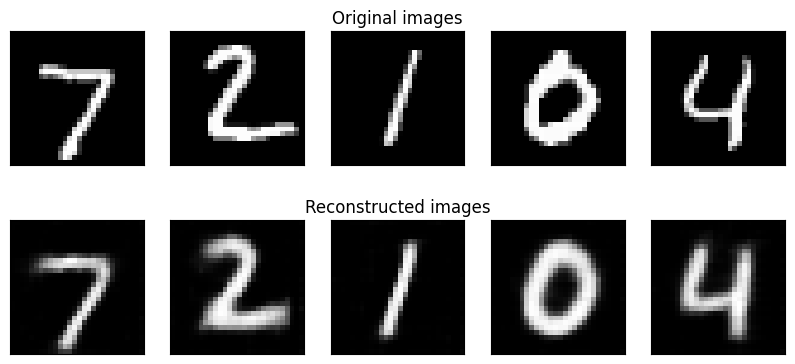

	 partial train loss (single batch): 8461.426758
	 partial train loss (single batch): 8081.273926
	 partial train loss (single batch): 8085.143555
	 partial train loss (single batch): 8055.698730
	 partial train loss (single batch): 8403.206055
	 partial train loss (single batch): 8288.277344
	 partial train loss (single batch): 8080.058105
	 partial train loss (single batch): 8513.340820
	 partial train loss (single batch): 7925.682617
	 partial train loss (single batch): 8152.085938
	 partial train loss (single batch): 7913.808594
	 partial train loss (single batch): 8078.948242
	 partial train loss (single batch): 8205.453125
	 partial train loss (single batch): 8394.322266
	 partial train loss (single batch): 7847.320312
	 partial train loss (single batch): 8032.354980
	 partial train loss (single batch): 8451.609375
	 partial train loss (single batch): 7913.635254
	 partial train loss (single batch): 8113.017578
	 partial train loss (single batch): 8044.638184
	 partial train loss

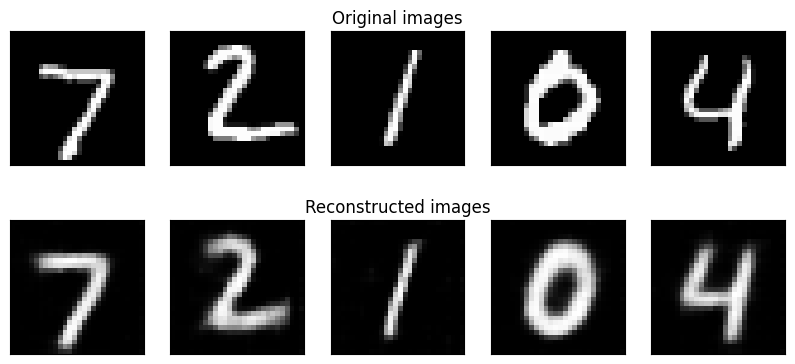

	 partial train loss (single batch): 8405.845703
	 partial train loss (single batch): 8139.707520
	 partial train loss (single batch): 8133.006836
	 partial train loss (single batch): 8093.637207
	 partial train loss (single batch): 8374.755859
	 partial train loss (single batch): 8237.933594
	 partial train loss (single batch): 8124.934570
	 partial train loss (single batch): 8540.068359
	 partial train loss (single batch): 7883.352539
	 partial train loss (single batch): 8095.568848
	 partial train loss (single batch): 7917.188965
	 partial train loss (single batch): 8050.167480
	 partial train loss (single batch): 8140.041016
	 partial train loss (single batch): 8345.473633
	 partial train loss (single batch): 7942.348633
	 partial train loss (single batch): 8019.963379
	 partial train loss (single batch): 8480.046875
	 partial train loss (single batch): 7948.577148
	 partial train loss (single batch): 8139.695312
	 partial train loss (single batch): 8069.710938
	 partial train loss

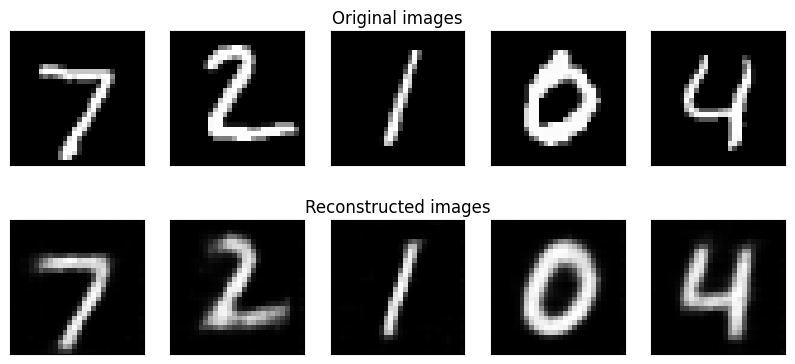

	 partial train loss (single batch): 8402.521484
	 partial train loss (single batch): 8128.577637
	 partial train loss (single batch): 8042.662109
	 partial train loss (single batch): 7979.663574
	 partial train loss (single batch): 8292.849609
	 partial train loss (single batch): 8186.551758
	 partial train loss (single batch): 8138.924805
	 partial train loss (single batch): 8466.273438
	 partial train loss (single batch): 7886.700195
	 partial train loss (single batch): 8216.154297
	 partial train loss (single batch): 7936.881348
	 partial train loss (single batch): 7979.927734
	 partial train loss (single batch): 8094.729492
	 partial train loss (single batch): 8436.979492
	 partial train loss (single batch): 7891.385742
	 partial train loss (single batch): 8003.916016
	 partial train loss (single batch): 8538.683594
	 partial train loss (single batch): 7925.605469
	 partial train loss (single batch): 8150.273438
	 partial train loss (single batch): 8061.208984
	 partial train loss

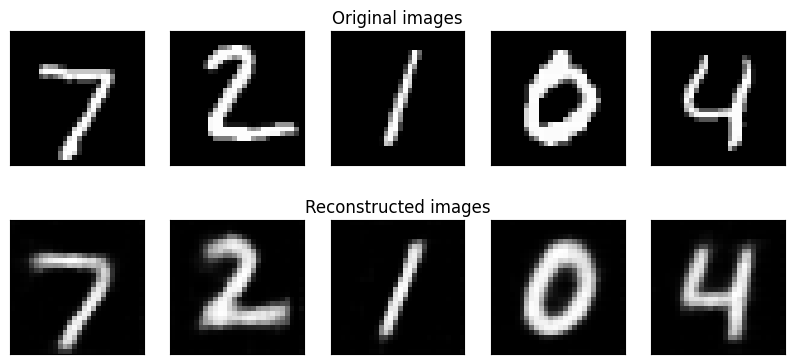

	 partial train loss (single batch): 8356.381836
	 partial train loss (single batch): 8216.443359
	 partial train loss (single batch): 8058.999512
	 partial train loss (single batch): 8073.695312
	 partial train loss (single batch): 8339.847656
	 partial train loss (single batch): 8190.356445
	 partial train loss (single batch): 8148.713867
	 partial train loss (single batch): 8524.490234
	 partial train loss (single batch): 7865.168945
	 partial train loss (single batch): 8156.032227
	 partial train loss (single batch): 7936.250000
	 partial train loss (single batch): 8060.184082
	 partial train loss (single batch): 8195.291016
	 partial train loss (single batch): 8385.502930
	 partial train loss (single batch): 7889.110352
	 partial train loss (single batch): 8059.465820
	 partial train loss (single batch): 8433.422852
	 partial train loss (single batch): 7869.191406
	 partial train loss (single batch): 8093.844727
	 partial train loss (single batch): 8195.359375
	 partial train loss

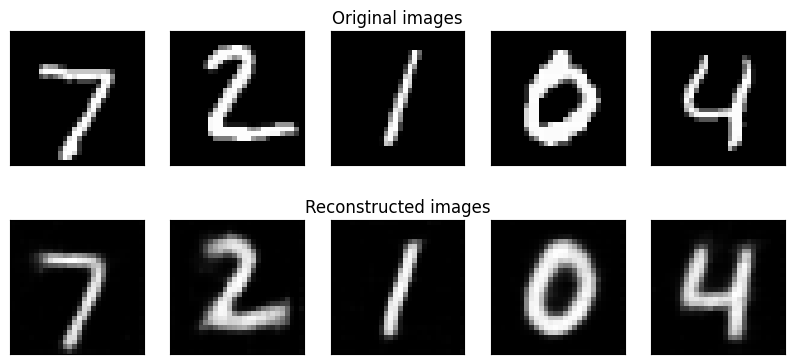

	 partial train loss (single batch): 8404.155273
	 partial train loss (single batch): 8125.977539
	 partial train loss (single batch): 8062.846191
	 partial train loss (single batch): 8061.145508
	 partial train loss (single batch): 8399.242188
	 partial train loss (single batch): 8187.948730
	 partial train loss (single batch): 8075.518066
	 partial train loss (single batch): 8515.179688
	 partial train loss (single batch): 7971.131836
	 partial train loss (single batch): 8129.020996
	 partial train loss (single batch): 7899.811523
	 partial train loss (single batch): 7987.304688
	 partial train loss (single batch): 8122.053223
	 partial train loss (single batch): 8249.644531
	 partial train loss (single batch): 7936.028809
	 partial train loss (single batch): 8054.962402
	 partial train loss (single batch): 8499.219727
	 partial train loss (single batch): 7910.055176
	 partial train loss (single batch): 8147.740234
	 partial train loss (single batch): 8088.800781
	 partial train loss

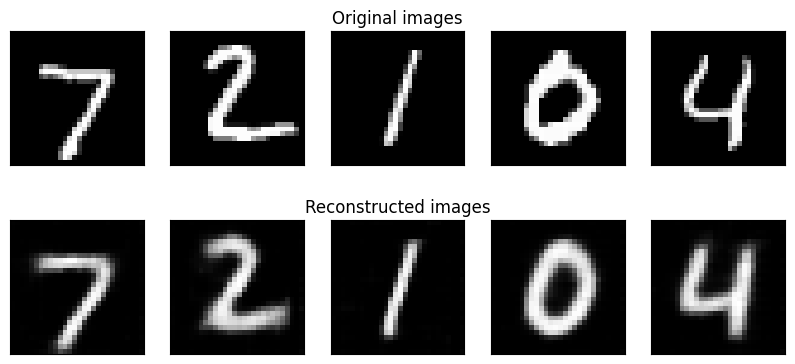

In [13]:
num_epochs = 50
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

## 4.Generate samples

In [14]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, 0, y, 0]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

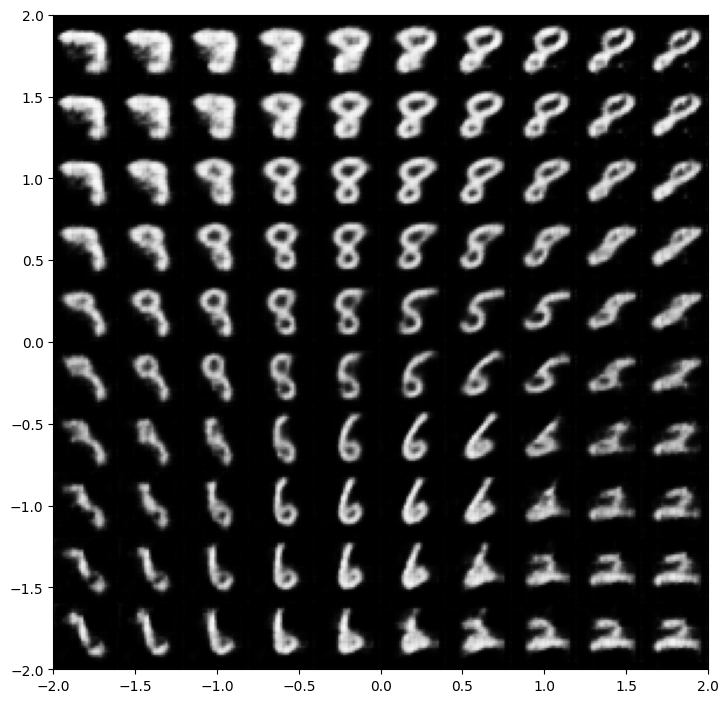

In [15]:
plot_reconstructed(vae.decoder, r0=(-2, 2), r1=(-2, 2))

## 5.Visualize latent space

In [16]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1313.21it/s]


In [17]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0           -0.744222        -0.032446         0.985456         1.418828   
1            0.710275         1.214910        -1.047532         0.997374   
2            0.385865        -0.770125        -0.437634         1.643112   
3            0.241203        -0.484196        -0.010791        -0.891730   
4           -0.355904        -1.213270        -0.161398        -0.550775   
...               ...              ...              ...              ...   
9995         0.456833         1.777723         0.124242         0.340735   
9996        -0.572683         1.475536        -0.475564        -0.304504   
9997         0.301542        -1.053859         0.141919         0.453083   
9998         1.106242        -0.505105         0.326102        -0.243669   
9999         0.294727        -0.021052        -1.300419        -1.089850   

      label  
0         7  
1         2  
2         1  
3         0  
4         4  
...     ...  
9995      2  
9996      3  
9997      4  
9998      5  
9999      6  

[10000 rows x 5 columns]

In [18]:
from sklearn.manifold import TSNE
import plotly.express as px

In [19]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [20]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

In [21]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()